# 1.  In  the  folder  “Exercises”  you  have  access  to  the  dataset  Titanic.csv presenting information about travellers with their status (survived=1(yes) or =0 (no)).  In  ddition, you have the information about the class(Pclass), name (Name), gender (Sex), age (Age), sibling or spouse onboard (1/0), parents or children aboard (1/0), and fare price (Fare)

In [1]:
import pandas as pd
import os


DATA_FILEPATH = "data/titanic.csv"

def fetch_data():
    """Import the data from csv to pd dataframe"""
    relaviteFilepath = os.path.join(os.path.abspath(''), DATA_FILEPATH)
    return pd.read_csv(relaviteFilepath)

# df stands for dataframe. This is the object that we will manipulate throughouht the notebook
titanicdf = fetch_data()
titanicdf

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


# Preprocessing
First we do some pre-processing to clean the data and/or transform it to be able to use it.

In [2]:
from sklearn import preprocessing

#The names need to be removed completely as they are a very problematic feature
titanicdf.drop(columns=["Name"], axis=1, inplace=True)

#The sex also needs to be encoded
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
titanicdf["Sex"] = le.fit_transform(titanicdf["Sex"])

#The Fare is numerical, we can try to arrange it into ranges
titanicdf["Fare_grouped"] = titanicdf["Fare"] // 10 #Group by 10

def group_age(age):
    """Directly use numbers as we would need to apply label encoder"""
    if age < 18:
        return 0
    if age < 30:
        return 1
    if age < 60:
        return 2
    return 3

#group ages
titanicdf['Age_grouped'] = titanicdf['Age'].apply(group_age)

print(titanicdf)

#Remove initial cols to avoid having very dependant values (simple + grouped, very bad for bayes)
titanicdf.drop(columns=['Fare', 'Age'], axis=1, inplace=True)

     Survived  Pclass  Sex   Age  Siblings/Spouses Aboard  \
0           0       3    1  22.0                        1   
1           1       1    0  38.0                        1   
2           1       3    0  26.0                        0   
3           1       1    0  35.0                        1   
4           0       3    1  35.0                        0   
..        ...     ...  ...   ...                      ...   
882         0       2    1  27.0                        0   
883         1       1    0  19.0                        0   
884         0       3    0   7.0                        1   
885         1       1    1  26.0                        0   
886         0       3    1  32.0                        0   

     Parents/Children Aboard     Fare  Fare_grouped  Age_grouped  
0                          0   7.2500           0.0            1  
1                          0  71.2833           7.0            2  
2                          0   7.9250           0.0            1  

## (a)  In the correlation visualization, select the two features that havethe most significant correlation to the target feature, Survived.

First we plot the correlation matrix

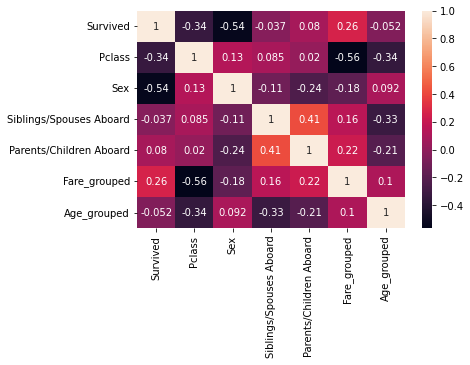

In [3]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = titanicdf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Then we study the column that is interesting for us - that is, the label (survived)

In [4]:
target = abs(corrMatrix["Survived"])

print(target)

Survived                   1.000000
Pclass                     0.336528
Sex                        0.542152
Siblings/Spouses Aboard    0.037082
Parents/Children Aboard    0.080097
Fare_grouped               0.260970
Age_grouped                0.051855
Name: Survived, dtype: float64


Now the two most relevant features can simply be selected amongst the bunch, excluding of course the Survived row.

In [5]:
featureCount = 2

#Drop the survived line
target.drop(labels="Survived", inplace=True)

#Oder the serie
ordered = target.sort_values(ascending=False)
print(f"Ordered : \n{ordered}")

#Select the N max
features = ordered[:featureCount]
print(f"{featureCount} most relevant features: \n{features}")

Ordered : 
Sex                        0.542152
Pclass                     0.336528
Fare_grouped               0.260970
Parents/Children Aboard    0.080097
Age_grouped                0.051855
Siblings/Spouses Aboard    0.037082
Name: Survived, dtype: float64
2 most relevant features: 
Sex       0.542152
Pclass    0.336528
Name: Survived, dtype: float64


* Note: We would not want to select PClass + Fare. They are indeed both relevant (Top3) but they are also highly correlated to each other
  * This is evident in the corellation matrix (0.56)
  * This is logical as they are directly linked

As the PClass is a bit more relevant, we would probably have better result by dropping the fare (tested in the point 3 with all attributes)

## (b)  Using Naive Bayes classifier and the most two significant features to predict the Survival of the travellers.

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X,y = titanicdf[["Sex", "Pclass"]], titanicdf["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = round(100*accuracy_score(y_test, y_pred), 1)
print(f"accuracy : {accuracy}%")

accuracy : 77.0%


## (c)  Compare the performance of your model when using all the attributes of the travellers.You need to split the dataset into two disjoint sample, the training and the test set.

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X,y = titanicdf.drop(columns=['Survived'], axis=1, inplace=False), titanicdf["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = round(100*accuracy_score(y_test, y_pred), 1)
print(f"accuracy : {accuracy}%")

accuracy : 77.5%


We try to remove the fare as it is highly correlated to the PClass to verify if dependant attributes are detrimental (in theory, they are)

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X,y = titanicdf.drop(columns=['Survived', 'Fare_grouped'], axis=1, inplace=False), titanicdf["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = round(100*accuracy_score(y_test, y_pred), 1)
print(f"accuracy : {accuracy}%")

accuracy : 77.3%


# Conclusion

By using the correlation matrix, we are able to determine which are the two features most correlated to the label (survived).\
Using these two independant features, Sex and Pclass, we achieve an accuracy of 79.7%.\
Using all the features together, we achieve a lower accuracy of 77.5%.\
By removing a highly dependant feature (fare_grouped highly dependant with the class), we achieve an even lower accuracy of 77.3%. The two numbers are still very close.\
\
We can conclude that taking the highly corellated features are  beneficial to the algorithm (+2% accuracy), and removing the fare did not change the result as much as I thought it would. Although it is important to keep in mind the method to group the fare is fairly arbitrary (grouped by value of 10: 0-10, 10-20, etc).\
\
Lastly, the pre-processing was very important (grouping age, encoding sex, etc) as the first pass without any encoding reached only ~66% of accuracy and dit not recognize the sex as a corelated feature